
There are 40 training instances of size 224 x 224
There are 21 test instances of size 224 x 224


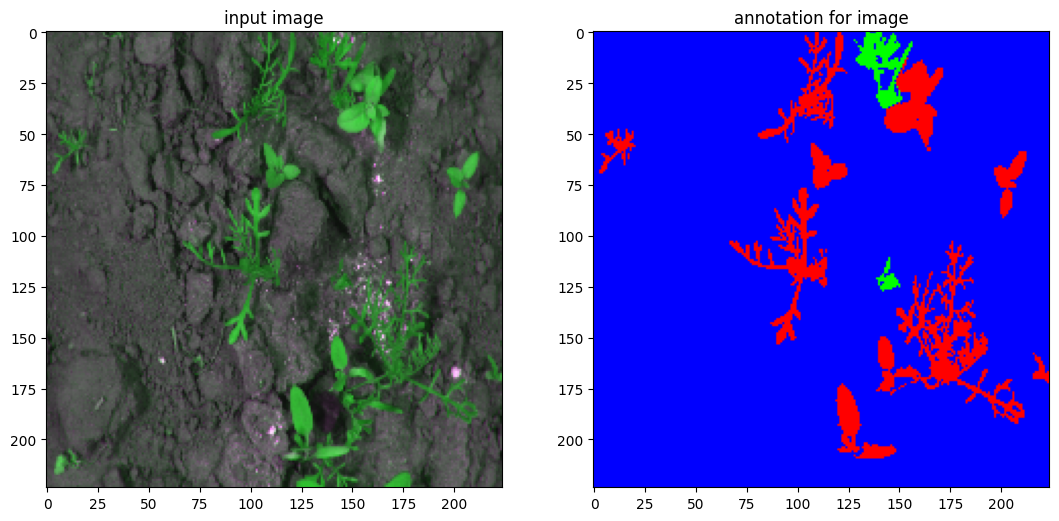

In [1]:

import numpy as np
np.random.seed(1)
from skimage.io import imread
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from PIL import Image


def load_segmentation_data():
  data = np.load('segmentation_data.npz')
  train_x = data['train_x']
  train_y = data['train_y']
  test_x = data['test_x']
  test_y = data['test_y']
  return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = load_segmentation_data()
print('There are %i training instances of size %i x %i' % (train_x.shape[0],train_x.shape[1],train_x.shape[2]))
print('There are %i test instances of size %i x %i' % (test_x.shape[0],test_x.shape[1],test_x.shape[2]))
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title("input image")
plt.imshow(train_x[0,:,:,:])

plt.subplot(1,3,2)
plt.title("annotation for image")
plt.imshow(train_y[0,:,:,:])



In [2]:
def segmentation_loss(y_true, y_pred):
    n, m, l , k = y_pred.shape
    losses_per_data = 0
    for i in range(n):
        loss_per_image = 0
        for j in range(m):
            for q in range(l):
                loss_per_image += (tf.keras.losses.categorical_crossentropy(y_true[i,j,q,:], y_pred[i,j,q,:]))
        loss_per_image /= m*l
        losses_per_data += loss_per_image
    return losses_per_data / (n)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, Dropout, MaxPooling2D
from tensorflow.keras import regularizers


In [5]:
def original_Unet():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom layer
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(3, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:


def exercise_defined_Unet(l2_regularization = 0.0001, dropoutRate = 0.2):
    inputs = Input(shape=(224, 224, 3), name='input_layer')
    
    # Downsampling
    L224_Conv2D = Conv2D(64, (3, 3), strides=(1,1),activation='relu', padding='same',  kernel_regularizer=regularizers.l2(l2_regularization), name='L224_Conv2D')(inputs)
    L112a_conv2D = Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='L112a_conv2D')(L224_Conv2D)
    L112_conv2d = Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='L112_conv2d')(L112a_conv2D)
    L56a_conv2d = Conv2D(128, (3, 3),  strides=(2,2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='L56a_conv2d')(L112_conv2d)
    L56_conv2d = Conv2D(128, (3, 3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='L56_conv2d')(L56a_conv2d)
    L28a_conv2d = Conv2D(256, (3, 3), strides=(2,2),activation='relu', padding='same',kernel_regularizer=regularizers.l2(l2_regularization), name='L28a_conv2d')(L56_conv2d)
    L28_conv2d = Conv2D(256, (3, 3),strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='L28_conv2d')(L28a_conv2d)
    L14a_conv2d = Conv2D(512, (3, 3),strides=(2,2), activation='relu', padding='same',kernel_regularizer=regularizers.l2(l2_regularization), name='L14a_conv2d')(L28_conv2d)
    L14_conv2d = Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='L14_conv2d')(L14a_conv2d)
    L14_conv2d = Dropout(dropoutRate)(L14_conv2d)
    # Upsampling
    conv2d_transpose = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d_transpose')(L14_conv2d)
    conv2d = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d')(conv2d_transpose)
    concatenate_conv2d_l28_conv2d = concatenate([conv2d, L28_conv2d], axis=3, name='concatenate_conv2d_l28_conv2d')

    conv2d_transpose1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d_transpose1')(concatenate_conv2d_l28_conv2d)
    conv2d1 = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(l2_regularization), name='conv2d1')(conv2d_transpose1)
    concatenate1_conv2d1_L56_conv2d = concatenate([conv2d1, L56_conv2d], axis=3, name='concatenate1_conv2d1_L56_conv2d')

    conv2d_transpose2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d_transpose2')(concatenate1_conv2d1_L56_conv2d)
    conv2d2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d2')(conv2d_transpose2)
    concatenate2_conv2d2_L112_conv2d = concatenate([conv2d2, L112_conv2d], axis=3, name='concatenate2_conv2d2_L112_conv2d')

    conv2d_transpose3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d_transpose3')(concatenate2_conv2d2_L112_conv2d)
    conv2d3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d3')(conv2d_transpose3)
    concatenate3_conv2d3_L224_Conv2D = concatenate([conv2d3, L224_Conv2D], axis=3, name='concatenate3_conv2d3_L224_Conv2D')

    conv2d4 = Conv2D(3, (1, 1), activation='softmax', kernel_regularizer=regularizers.l2(l2_regularization),name='conv2d4')(concatenate3_conv2d3_L224_Conv2D)
    model = Model(inputs=inputs, outputs=conv2d4)    
    return model




In [14]:
model = exercise_defined_Unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=20, batch_size=8)
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/20
5/5 [==============================] - 23s 4s/step - loss: 1.1787 - accuracy: 0.7343
Epoch 2/20
5/5 [==============================] - 17s 3s/step - loss: 0.5899 - accuracy: 0.9256
Epoch 3/20
5/5 [==============================] - 17s 3s/step - loss: 0.4929 - accuracy: 0.9256
Epoch 4/20
5/5 [==============================] - 17s 3s/step - loss: 0.4370 - accuracy: 0.9256
Epoch 5/20
5/5 [==============================] - 17s 3s/step - loss: 0.3793 - accuracy: 0.9256
Epoch 6/20
5/5 [==============================] - 17s 3s/step - loss: 0.3207 - accuracy: 0.9256
Epoch 7/20
5/5 [==============================] - 17s 4s/step - loss: 0.2618 - accuracy: 0.9256
Epoch 8/20
5/5 [==============================] - 17s 3s/step - loss: 0.2238 - accuracy: 0.9256
Epoch 9/20
5/5 [==============================] - 17s 3s/step - loss: 0.2034 - accuracy: 0.9321
Epoch 10/20
5/5 [==============================] - 18s 4s/step - loss: 0.1913 - accuracy: 0.9574
Epoch 11/20
5/5 [======================

1/1 [==============================] - 2s 2s/step


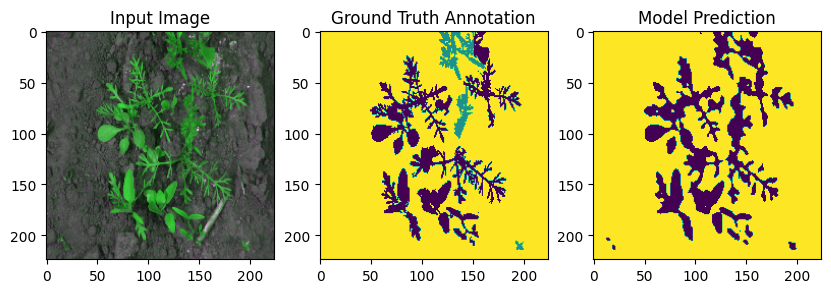

In [15]:
predictions = model.predict(test_x)
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_x[0])

plt.subplot(1, 3, 2)
plt.title("Ground Truth Annotation")
plt.imshow(np.argmax(test_y[0], axis=-1), cmap='viridis')

plt.subplot(1, 3, 3)
plt.title("Model Prediction")
plt.imshow(np.argmax(predictions[0], axis=-1), cmap='viridis')
plt.show()